<a href="https://colab.research.google.com/github/shreya0202/ImageClassification/blob/main/ImageClass_Caltech256_vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mounting Drive

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Importing Libraries

import os
import gc
import time
import numpy as np
from matplotlib import pyplot as plt
from zipfile import ZipFile
from PIL import Image
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import img_to_array, load_img
from keras.layers import Dense, Flatten, Dropout, Reshape, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.callbacks import TensorBoard
from keras.callbacks import EarlyStopping

In [ ]:
# Defining Caltech 256 dataset path

if('caltech256_dataset' not in os.listdir('/content/drive/MyDrive/')):
    zippath = '/content/drive/MyDrive/256_ObjectCategories.zip' 
    with ZipFile(zippath, 'r') as zipref:
        zipref.extractall('/content/drive/MyDrive/caltech256_dataset') 
        

In [ ]:
data_path = '/content/drive/MyDrive/caltech256_dataset/256_ObjectCategories/' 

In [ ]:
# Checking total classes in dataset

folders = os.listdir(data_path)
folders.sort()
num_classes = len(folders)
print("Number of classes: {}".format(num_classes))

Number of classes: 257


In [ ]:
os.chdir('/content/drive/MyDrive')

In [ ]:
import math
import shutil

# Splitting data: 30 image per class for training dataset, remaining images are used for testing

if('caltech_test' not in os.listdir('/content/drive/MyDrive/')):
  os.mkdir("caltech_test") # stores test data

  for cat in os.listdir(data_path):
    os.mkdir("/content/drive/MyDrive/caltech_test/"+cat) # new folder
    imgs = os.listdir(data_path + cat) # all image filenames 
    test_imgs = imgs[30:len(imgs)] # selecting all but 30 images
    for t_img in test_imgs: # move test portion
      shutil.move(data_path +cat+"/"+t_img, "/content/drive/MyDrive/caltech_test/"+cat+"/"+t_img)

In [ ]:
# backup whole dataset in a folder
# if('dataset_caltech256' not in os.listdir('/content/drive/MyDrive/')):
#     zippath = '/content/drive/MyDrive/256_ObjectCategories.zip' 
#     with ZipFile(zippath, 'r') as zipref:
#         zipref.extractall('/content/drive/MyDrive/dataset_caltech256') 

In [ ]:
# Calling VGG16 model for random weights

vgg0 = VGG16(weights=None, input_shape=(224, 224, 3), include_top=True, classes=257)

In [ ]:
# Calling VGG16 modell for imagenet weights

vgg1 = VGG16(weights='imagenet', input_shape=(224, 224, 3), include_top=False, classes=257)

In [ ]:
# Garbage Collection

gc.collect()

0

In [ ]:
# Freeze all the layers

for layer in vgg0.layers[:]:
    layer.trainable = False

# Check the trainable status of the individual layers

for layer in vgg0.layers:
  print(layer, layer.trainable)


<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f8774758278> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f87b0971278> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f87b095c978> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f87a46e4ac8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f87a46e4cc0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f87746beba8> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f87601a52e8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f87601a5b38> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f87601af9b0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f87601afa58> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f87601b99b0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 

In [ ]:
# Freeze all the layers

for layer in vgg1.layers[:]:
    layer.trainable = False

# Check the trainable status of the individual layers

for layer in vgg1.layers:
  print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fe7901ad080> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fe7901a3240> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fe7901a3d30> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fe502fbc240> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fe502fb21d0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fe7901a3358> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fe502fc5c50> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fe502fc54e0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fe502fbca20> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fe502fcaeb8> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fe502fd4eb8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 

In [ ]:
# Creating layers for Model 0

x0 = vgg0.get_layer('block5_pool').output
x0 = Flatten(name='flatten')(x0)
x0 = Dense(4096, activation='relu', name='dense1')(x0)
x0 = BatchNormalization()(x0)
x0 = Dropout(0.25)(x0)
x0 = Dense(4096, activation='relu', name='dense2')(x0)
x0 = BatchNormalization()(x0)
x0 = Dropout(0.25)(x0)
x0 = Dense(257, activation='softmax', name='classifier')(x0)

new_model_0 = Model(inputs=vgg0.input, outputs=x0)

new_model_0.save_weights('/content/drive/MyDrive/caltech_initial_model_0.h5')

new_model_0.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [ ]:
# Creating layers for Model 1

x1 = vgg1.output
x1 = Flatten(name='flatten')(x1)
x1 = Dense(1024, activation='relu', name='dense1')(x1)
# x1 = Dropout(0.3)(x1)
x1 = Dense(1024, activation='relu', name='dense2')(x1)
x1 = Dropout(0.25)(x1)
x1 = Dense(257, activation='softmax', name='classifier')(x1)

new_model_1 = Model(inputs=vgg1.input, outputs=x1)

new_model_1.save_weights('/content/drive/MyDrive/caltech_initial_model_1.h5')

new_model_1.summary()

Model: "functional_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)     

In [ ]:
# Using ImageDataGenerator to get train and test data
import tensorflow as tf

image_size = 224
train_batchsize = 32
test_batchsize = 10

new_path = '/content/drive/MyDrive/caltech_test'
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
datagen1 = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(data_path, 
                                            target_size=(image_size, image_size), 
                                            batch_size=test_batchsize, # subset = 'validation',
                                            class_mode='categorical')

val_generator = datagen1.flow_from_directory(new_path, 
                                              target_size=(image_size, image_size), 
                                              batch_size=train_batchsize, # subset = 'training',
                                              class_mode='categorical')







Found 7710 images belonging to 257 classes.
Found 22897 images belonging to 257 classes.


In [ ]:
# Creating Log files for Model 1

tensorboard_model0_caltech = TensorBoard(log_dir='/content/drive/MyDrive/logs_caltech/model_0/{}'.format(time.time()))
tensorboard_model1_caltech = TensorBoard(log_dir='/content/drive/MyDrive/logs_caltech/model_1/{}'.format(time.time()))

In [ ]:
# Training and Testing Model 0 for VGG16 with imagenet weights
import time
training_runs_model0 = []

for i in range(3):
    start_time = time.time()
    new_model_0.compile(optimizer=keras.optimizers.RMSprop(lr=1e-4), loss='categorical_crossentropy', metrics=['acc'])
    print("Training Run #{}\n".format(i+1))
    model_history = new_model_0.fit(train_generator, epochs=20, validation_data=val_generator, callbacks=[tensorboard_model1_caltech])
    end_time = time.time()
    training_runs_model0.append(model_history)
    new_model_0.get_weights()
    if(i == 2):
        new_model_0.save_weights('/content/drive/MyDrive/caltech_final_model_0.h5')
    else:
        new_model_0.load_weights('/content/drive/MyDrive/caltech_initial_model_0.h5')
    print(f"Training time: {end_time - start_time}s")
    print("\n\n")

Training Run #1

Epoch 1/20
771/771 [==============================] - 187s 243ms/step - loss: 5.1396 - acc: 0.0598 - val_loss: 5.3057 - val_acc: 0.0550
Epoch 2/20
771/771 [==============================] - 187s 242ms/step - loss: 5.0692 - acc: 0.0686 - val_loss: 5.2841 - val_acc: 0.0804
Epoch 3/20
771/771 [==============================] - 188s 244ms/step - loss: 5.0188 - acc: 0.0780 - val_loss: 5.3071 - val_acc: 0.0678
Epoch 4/20
771/771 [==============================] - 188s 244ms/step - loss: 4.9822 - acc: 0.0827 - val_loss: 5.1980 - val_acc: 0.0739
Epoch 5/20
771/771 [==============================] - 188s 244ms/step - loss: 4.9430 - acc: 0.0895 - val_loss: 5.2743 - val_acc: 0.0665
Epoch 6/20
771/771 [==============================] - 189s 245ms/step - loss: 4.8831 - acc: 0.1048 - val_loss: 5.2836 - val_acc: 0.0722
Epoch 7/20
771/771 [==============================] - 188s 244ms/step - loss: 4.8323 - acc: 0.1134 - val_loss: 5.2119 - val_acc: 0.0589
Epoch 8/20
771/771 [===========

In [ ]:
# Training and Testing Model 1 for VGG16 with imagenet weights
import time
training_runs_model1 = []

for i in range(3):
    start_time = time.time()
    new_model_1.compile(optimizer=keras.optimizers.RMSprop(lr=1e-4), loss='categorical_crossentropy', metrics=['acc'])
    print("Training Run #{}\n".format(i+1))
    model_history = new_model_1.fit(train_generator, epochs=20, validation_data=val_generator, callbacks=[tensorboard_model1_caltech])
    end_time = time.time()
    training_runs_model1.append(model_history)
    new_model_1.get_weights()
    if(i == 2):
        new_model_1.save_weights('/content/drive/MyDrive/caltech_final_model_1.h5')
    else:
        new_model_1.load_weights('/content/drive/MyDrive/caltech_initial_model_1.h5')
    print(f"Training time: {end_time - start_time}s")
    print("\n\n")

Training Run #1

Epoch 1/20
771/771 [==============================] - 165s 215ms/step - loss: 4.8859 - acc: 0.0803 - val_loss: 3.6715 - val_acc: 0.2552
Epoch 2/20
771/771 [==============================] - 165s 214ms/step - loss: 2.8687 - acc: 0.3519 - val_loss: 2.7294 - val_acc: 0.4003
Epoch 3/20
771/771 [==============================] - 165s 214ms/step - loss: 1.7578 - acc: 0.5725 - val_loss: 2.3629 - val_acc: 0.4578
Epoch 4/20
771/771 [==============================] - 165s 214ms/step - loss: 1.0481 - acc: 0.7371 - val_loss: 2.3832 - val_acc: 0.4558
Epoch 5/20
771/771 [==============================] - 165s 214ms/step - loss: 0.5888 - acc: 0.8562 - val_loss: 2.3195 - val_acc: 0.4855
Epoch 6/20
771/771 [==============================] - 165s 214ms/step - loss: 0.3280 - acc: 0.9204 - val_loss: 2.4104 - val_acc: 0.4809
Epoch 7/20
771/771 [==============================] - 165s 214ms/step - loss: 0.1847 - acc: 0.9551 - val_loss: 2.5267 - val_acc: 0.4864
Epoch 8/20
771/771 [===========

In [ ]:
tr_acc_mod0_0 = training_runs_model0[0].history['acc']
tr_acc_mod0_1 = training_runs_model0[1].history['acc']
tr_acc_mod0_2 = training_runs_model0[2].history['acc']

tr_acc_mod1_0 = training_runs_model1[0].history['acc']
tr_acc_mod1_1 = training_runs_model1[1].history['acc']
tr_acc_mod1_2 = training_runs_model1[2].history['acc']

ts_acc_mod0_0 = training_runs_model0[0].history['val_acc']
ts_acc_mod0_1 = training_runs_model0[1].history['val_acc']
ts_acc_mod0_2 = training_runs_model0[2].history['val_acc']

ts_acc_mod1_0 = training_runs_model1[0].history['val_acc']
ts_acc_mod1_1 = training_runs_model1[1].history['val_acc']
ts_acc_mod1_2 = training_runs_model1[2].history['val_acc']

tot_tr_acc_mod0 = max(tr_acc_mod0_0) + max(tr_acc_mod0_1) + max(tr_acc_mod0_2)
avg_tr_acc_mod0 = tot_tr_acc_mod0 / 3
print("Avg training accuracy (random weights): {}".format(avg_tr_acc_mod0))

tot_tr_acc_mod1 = max(tr_acc_mod1_0) + max(tr_acc_mod1_1) + max(tr_acc_mod1_2)
avg_tr_acc_mod1 = tot_tr_acc_mod1 / 3
print("Avg training accuracy (\'imagenet\' weights): {}".format(avg_tr_acc_mod1))

print()

tot_ts_acc_mod0 = max(ts_acc_mod0_0) + max(ts_acc_mod0_1) + max(ts_acc_mod0_2)
avg_ts_acc_mod0 = tot_ts_acc_mod0 / 3
print("Avg testing accuracy (random weights): {}".format(avg_ts_acc_mod0))

tot_ts_acc_mod1 = max(ts_acc_mod1_0) + max(ts_acc_mod1_1) + max(ts_acc_mod1_2)
avg_ts_acc_mod1 = tot_ts_acc_mod1 / 3
print("Avg testing accuracy (\'imagenet\' weights): {}".format(avg_ts_acc_mod1))

Avg training accuracy (random weights): 0.34172070026397705
Avg training accuracy ('imagenet' weights): 0.9967333333333334

Avg testing accuracy (random weights): 0.10714649657408397
Avg testing accuracy ('imagenet' weights): 0.5183333333333333


In [ ]:
# Function to plot data

def plotData(epochs, mod0, mod1, title):
  plt.plot(range(epochs), mod0, 'or-', label='Random Weights')
  plt.plot(range(epochs), mod1, 'ob-', label='ImageNet Weights')
  plt.legend()
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.title(title)
  plt.show()

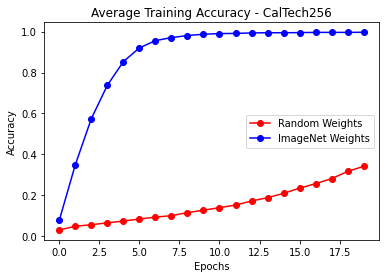

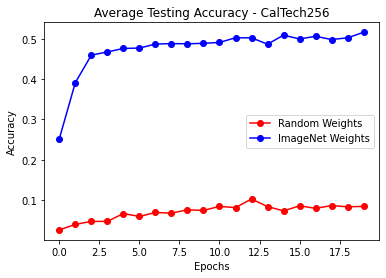

In [ ]:
# Plotting Mean Train and Test accuracies for Model 0 and 1

epochs = 20

mean_tr_acc_mod0 = np.add(np.add(tr_acc_mod0_0, tr_acc_mod0_1), tr_acc_mod0_2) / 3
mean_tr_acc_mod1 = np.add(np.add(tr_acc_mod1_0, tr_acc_mod1_1), tr_acc_mod1_2) / 3

mean_ts_acc_mod0 = np.add(np.add(ts_acc_mod0_0, ts_acc_mod0_1), ts_acc_mod0_2) / 3
mean_ts_acc_mod1 = np.add(np.add(ts_acc_mod1_0, ts_acc_mod1_1), ts_acc_mod1_2) / 3

title1 = 'Average Training Accuracy - CalTech256'
title2 = 'Average Testing Accuracy - CalTech256'
plotData(epochs, mean_tr_acc_mod0, mean_tr_acc_mod1, title1)
plotData(epochs, mean_ts_acc_mod0, mean_ts_acc_mod1, title2)
